# Imports

In [1]:
import mdtraj as md
import numpy as np
import pandas as pd
import encodermap as em
import loading_lizard as ll
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import nglview as ngl
import xarray as xr
import expansion_elephant as ep
import tensorflow as tf
import running_rabbit as rr
import sys
sys.path.insert(0, '/home/kevin/git/Backward/')
import backward
rr.update_gmx_environ('2021.1', cuda=True, AVX512=True)

import glob, os, re, copy, pickle, hdbscan, subprocess, itertools, pathlib, pyemma, shutil, time
%matplotlib notebook
%load_ext autoreload
%autoreload 2

/home/kevin/projects/encoder_map_private/encodermap/misc/transformations.py:1901: UserWarning: failed to import module transformations._transformations
  warnings.warn("failed to import module %s" % name)


sourcing /home/soft/gromacs/gromacs-2021.1/inst/cuda_shared_AVX_512_20.04/bin/GMXRC.bash ...


# Find sims

In [12]:
def os_walk(dir_, resolution='aa'):
    traj_files = []
    pdb_files = []
    for root, dirs, files in os.walk(dir_, topdown=False):
        if 'preproc' in root or 'triUBQ' in root or 'tetraUBQ' in root:
            continue
        if 'k6' in root.lower() and not 'k63' in root.lower() and not 'monoub' in root.lower():
            for name in files:
                if name.endswith('xtc'):
                    if 'comp' in name:
                        found_file = os.path.join(root, name)
                        if check_ff(root, resolution=resolution):
                            traj_files.append(found_file)
                            pdb_files.append(os.path.join(root, 'confout.gro'))
                    elif 'nojump' in name:
                        found_file = os.path.join(root, name)
                        if check_ff(root, resolution=resolution):
                            traj_files.append(found_file)
                            pdb_files.append(os.path.join(root, 'start.pdb'))
                    elif name == 'traj.xtc':
                        pass
                    else:
                        print(name)
                        print(root)
                        print(os.listdir(root))
                        raise Exception("Unkown traj name.")
            for name in dirs:
                pass
    return traj_files, pdb_files
            
def check_ff(dir_, resolution='aa'):
    pdb_file = os.path.join(dir_, 'start.pdb')
    top_file = os.path.join(dir_, 'system.top')
    gro_file = os.path.join(dir_, 'confout.gro')
    if os.path.isfile(pdb_file):
        file = pdb_file
    elif os.path.isfile(top_file):
        file = top_file
    elif os.path.isfile(gro_file):
        file = gro_file
    else:
        print(dir_)
        print(os.listdir(dir_))
        raise Exception("Could not find start.pdb, system.top or confout.gro")
        
    with open(file, 'r') as f:
        line = f.readline()
        line2 = f.readline()
    if 'martini' in line.lower():
        out = False
    elif 'protein in water' in line.lower():
        out =  True
    elif 'top_G54A7' in line2:
        out =  True
    elif '[ defaults ]' in line:
        with open(file, 'r') as f:
            lines = f.read()
        if 'MARTINI' in lines:
            out =  False
        else:
            print(lines)
            raise Exception("Could not find system type in full topology file.")
    else:
        print(file)
        print(line)
        raise Exception("Unkonw system type")
        
    if resolution == 'cg':
        return not out
    return out
            
sims_dir = '/home/andrejb/Research/SIMS/'
aa_trajs, aa_pdbs = os_walk(sims_dir)
cg_trajs, cg_pdbs = os_walk(sims_dir, resolution='cg')

# Load lowd data

In [3]:
trajs = []
for traj_file, top_file in zip(aa_trajs, aa_pdbs):
    trajs.append(em.Info_single(traj_file, top_file))
trajs = em.Info_all(trajs)

In [4]:
for traj in trajs:
    new_basename = traj.traj_file.split('/')[-2]
    lowd_file = f'AA_and_CG_pairwise_distances/{new_basename}.npy'
    traj.load_CV(lowd_file, 'lowd')

<IPython.core.display.Javascript object>


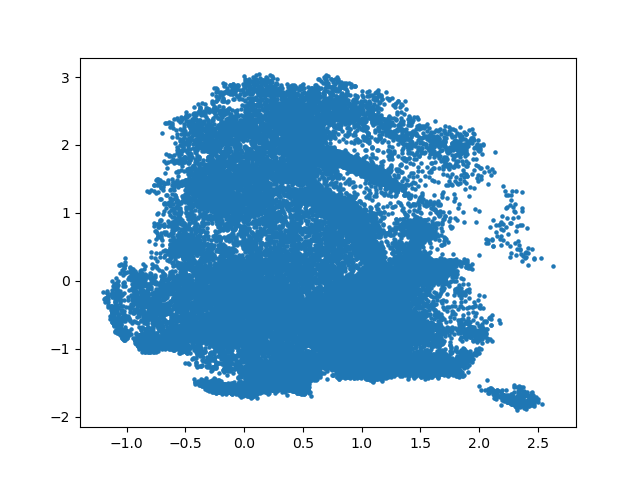

In [7]:
plt.scatter(*trajs.lowd[:,:2].T, s=5)

# Cluster that data

In [8]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=100, cluster_selection_method='leaf').fit(trajs.lowd)

In [10]:
np.save('clusterer_AA_labels_trained_with_complete.npy', clusterer.labels_)

In [14]:
from encodermap.misc.xarray import add_one_by_one
splits = add_one_by_one([traj.lowd.shape[1] for traj in trajs])[:-1]
splitted_cluster_labels = np.split(clusterer.labels_, splits)
print(len(splitted_cluster_labels), trajs.n_trajs)
assert all([trajs[i].lowd.shape[1] == len(splitted_cluster_labels[i]) for i in range(trajs.n_trajs)])
for i, traj in enumerate(trajs):
    traj.load_CV(splitted_cluster_labels[i], 'cluster_membership')

57 57


In [44]:
def renumber_pdb_for_psolpot(file):
    printed_already_renumbered = False
    with open(file, 'r') as f:
        lines = f.read().splitlines()
    new_lines = []
    increase = False
    for l in lines:
        if 'ATOM' in l:
            if increase:
                old_int = l[22:27]
                if int(old_int) >= 77:
                    if not printed_already_renumbered:
                        print('already renumbered')
                        printed_already_renumbered = True
                    increase = False
                    new_lines.append(l)
                else:
                    new_int = f"{int(l[22:27]) + 76:>4}"   ## Sure that this should be 75 and not 76?
                    l = l.replace(old_int, new_int)
                    new_lines.append(l)
            else:
                new_lines.append(l)
            if int(l[22:27]) >= 75 and 'O   GLY A' in l:
                increase = True
        elif 'TER    1506      GLY A  76' in l:
            l = 'TER    1506      GLY A 151'
            new_lines.append(l)
        else:
            new_lines.append(l)
    os.remove(file)
    with open(file, 'w') as f:
        f.writelines('\n'.join(new_lines))

In [47]:
basedir = 'AA_clusters_trained_with_complete/'
os.makedirs(basedir, exist_ok=True)

# XPLOR
relax_pot_file = '/home/kevin/projects/tobias_schneider/diUbi_600_mhz_relaxratiopot_in.tbl'
spre_file = '/home/kevin/projects/tobias_schneider/diUbi_spre_in.tbl'
temp = 300.0
freq = 600.0
nsteps = 500
overwrite = True

# Some lists with basenames
cg_basenames = list(map(lambda x: x.split('/')[-2], cg_trajs))
aa_basenames = list(map(lambda x: x.split('/')[-2], aa_trajs))

# traj that has worked with XPLOR:
working_traj = md.load('CA_distances_neighbor_excluded_all_trajs_clusters/0/cluster_0_rmsd_centroid_full.pdb')

# basenames of trajs with same length as cluster_membership
name_arr = []
for traj in trajs:
    name_arr.extend([traj.traj_file.split('/')[-2] for i in range(len(traj.cluster_membership))])
name_arr = np.array(name_arr)

for cluster_num in range(clusterer.labels_.max()):
    cluster_basedir = basedir + f'{cluster_num}'
    os.makedirs(cluster_basedir, exist_ok=True)
    
    # some file definitions
    full_cluster_out = cluster_basedir + f'/cluster_{cluster_num}_cart_centroid_full.pdb'
    cluster_out_pdb = cluster_basedir + f'/cluster_{cluster_num}_cart_centroid.pdb'
    xplor_out_pdb = cluster_basedir + f'/cluster_{cluster_num}_cart_centroid_sim.pdb'
    if os.path.isfile(xplor_out_pdb) or not overwrite:
        print('already exists')
        continue
    
    # euclidean center
    where = np.where(trajs.cluster_membership == cluster_num)[0]
    cluster_points = trajs.lowd[where]
    cart_centroid = np.mean(cluster_points, axis=0)
    dists = np.sum((cluster_points - cart_centroid)**2, axis=1)
    clostest_point_index = np.argmin(dists)
    
    # find the frame of the closest point
    if not os.path.isfile(cluster_out_pdb) or overwrite:
        
        # iterate over trajs(frames) until index is met
        index = where[clostest_point_index]
        current = 0
        for traj in trajs:
            if len(traj.cluster_membership) + current < index:
                current += len(traj.cluster_membership)
                continue
            else:
                remainder = index - current
                frame = md.load_frame(traj.traj_file, top=traj.top_file, index=remainder)
                break

        # do backmapping if traj is CG
        if traj.traj_file in cg_trajs:
            # files for backmapping
            raise Exception("This should not happen.")
            aa_gro = cluster_basedir + f'/cluster_{cluster_num}_cart_centroid_AA.gro'
            cg_pdb = cluster_basedir + f'/cluster_{cluster_num}_cart_centroid_CG.pdb'
            
            # do backmapping
            if not os.path.isfile(aa_gro):
                frame.save_pdb(cg_pdb)
                prepare_pdb_for_backmap(cg_pdb)
                backmap(cg_pdb, aa_gro, cluster_basedir + '/em_after_backmap')
            else:
                print(f"CG {aa_gro} already_exists.")
                
            # load output from backmapping
            gro_traj = md.load(aa_gro)
            gro_traj.save_pdb(full_cluster_out)
            renumber_pdb_for_psolpot(full_cluster_out)
            _ = gro_traj.top.select("(resid 75 and resname GLY) or (index 819 to 831)")
            assert len(_) == 19, print(len(_))
            
            gro_traj = gro_traj.atom_slice(gro_traj.top.select("not (resname GLY and name OXT)"))
            gro_traj = gro_traj.atom_slice(gro_traj.top.select("not (index 826 or index 827)"))
            
            adjusted_traj = copy.deepcopy(working_traj)
            adjusted_traj.xyz[:,:-1] = gro_traj.xyz
            
            assert gro_traj.n_atoms == working_traj.n_atoms - 1
            
            # remove LYS and GLY isopeptides, that previously have been renamed
            # gro_traj = gro_traj.atom_slice(gro_traj.top.select("not ((resid 75 and resname GLY) or (index 819 to 831))"))
            adjusted_traj.save_pdb(full_cluster_out)
            adjusted_traj = adjusted_traj.atom_slice(adjusted_traj.top.select("not resname LYQ and not resname GLQ"))
            adjusted_traj.save_pdb(cluster_out_pdb)
            renumber_pdb_for_psolpot(cluster_out_pdb)
        else:
            # save the files
            frame.save_pdb(full_cluster_out)
            frame = frame.atom_slice(frame.top.select("not resname LYQ and not resname GLQ"))
            frame.save_pdb(cluster_out_pdb)
            renumber_pdb_for_psolpot(cluster_out_pdb)
    else:
        print(f"{cluster_out_pdb} already exists. Continuing.")
    
    # check if cluster is possible and write where
    if all([i in cg_basenames for i in name_arr[where]]):
        np.save(cluster_basedir + f'/cluster_{cluster_num}_all_cg_where.npy', where)
    elif all([i in aa_basenames for i in name_arr[where]]):
        np.save(cluster_basedir + f'/cluster_{cluster_num}_all_aa_where.npy', where)
    else:
        np.save(cluster_basedir + f'/cluster_{cluster_num}_mixed_where.npy', where)
        
    cmd = f'./run_psolpot_and_r_ratio_dyn.py -pdb {cluster_out_pdb} -psol_restraints {spre_file} -relax_restraints {relax_pot_file} -out_pdb {xplor_out_pdb} -temp {temp} -freq {freq} -nsteps {nsteps}'
    print(cmd)
    subprocess.call(cmd, shell=True)

already exists
already exists
already exists
already exists
already exists
already exists
already exists
already exists
already exists
already exists
already exists
already exists
already exists
already exists
already exists
already exists
already exists
already exists
already exists
already exists
already exists
already exists
already exists
already exists
already exists
already exists
already exists
already exists
./run_psolpot_and_r_ratio_dyn.py -pdb AA_clusters_trained_with_complete/28/cluster_28_cart_centroid.pdb -psol_restraints /home/kevin/projects/tobias_schneider/diUbi_spre_in.tbl -relax_restraints /home/kevin/projects/tobias_schneider/diUbi_600_mhz_relaxratiopot_in.tbl -out_pdb AA_clusters_trained_with_complete/28/cluster_28_cart_centroid_sim.pdb -temp 300.0 -freq 600.0 -nsteps 500
already exists
already exists
already exists
already exists
./run_psolpot_and_r_ratio_dyn.py -pdb AA_clusters_trained_with_complete/33/cluster_33_cart_centroid.pdb -psol_restraints /home/kevin/proj

In [24]:
frame.save_pdb(cluster_out_pdb)